#### Project in CMPE 252, Spring 2022, SJSU.

**Model-free learing in the tabular case by Q-learning**.

Team 10:
<br>
Wooyoung Chung, Johnny Liang, and Dazhou Lui

In [1]:
#Importing the necessary libraries:
import matplotlib.pyplot as plt

from IPython.display import clear_output
import numpy as np
import random
import copy
%matplotlib inline

In [2]:
GRID_SIZE = 17

# rewards
R_GOAL = 0
R_HIT_WALL = -5
R_STEP = -1 # each step is penalized, which encourage the agent
            # to look for the shortest path to the goal state

START = (0, 0)
GOAL = (GRID_SIZE - 1, GRID_SIZE - 1)

# Action Space
A = [
    (-1, 0),    # 'up'
    (1, 0),     # 'down'
    (0, -1),    # 'left'
    (0, 1),     # 'right'
    (0, 0)      # 'stay'
]

# Noise in transition 
ALPHA = 0.01


A_LIST = ['up', 'down', 'left', 'right', 'stay']

# lenght of an episode
EPISODE_LENGTH_MAX = 400

Define the Maze. 0 - no wall, 1 - horizontal wall no the bottom of the cell, 2 - vertical wall on the right of the cell

In [3]:
# State Space
S = np.zeros((GRID_SIZE, GRID_SIZE))

# horizontal walls
S[3, 0:12] = 1
S[5, 10: ] = 1
S[8, 3:12] = 1
S[11, 4: ] = 1

# vertical walls
S[8:12, 2] = 2

# goal state
S[GOAL]    = 3

Visualize the maze

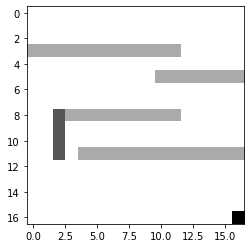

In [4]:
plt.imshow(S, cmap='binary')

State transition dynamics check

In [5]:
def hit_wall(curr, action):
    '''This function checks if the agent hits any walls.
    : param curr: Current position of the agent
    : param action: Chosen action by the agent
    : returns: True/False Binary value to indicate if agent hits a wall
    '''
    s_new = (
        curr[0] + A[action][0],
        curr[1] + A[action][1]
    )

    # Check for grid boundaries
    if min(s_new) < 0 or max(s_new) > GRID_SIZE - 1:
        return True

    # Check walls
    # 0: 'up':   (-1,  0),
    # 1: 'down': ( 1,  0),
    # 2: 'left': ( 0, -1),
    # 3: 'right':( 0,  1),
    # 4: 'stay': ( 0,  0)
    if (S[curr]==1 and action==1) \
        or (S[curr]==2 and action==3) \
        or (S[s_new]==1 and action==0)\
        or (S[s_new]==2 and action==2):
        return True

    return False

In [6]:
def R(s, a):
    '''Reward function for the agent
    : param s: Current state of the agent
    : param a: Action the agent takes at the current state
    : returns: Reward for the action at current state
    '''
    if s == GOAL:
        return R_GOAL
    elif hit_wall(s, a):
        return R_HIT_WALL
    else:
        return R_STEP

In [7]:
def s_next_calc(s, a):
    '''This function returns the agent's next state given action
    and current state (assuming the action succeeds).
    : param s: Current position of the agent
    : param a: Chosen action by the agent
    : returns: New state coordinates in the grid
    '''
    return (s[0] + A[a][0], s[1] + A[a][1])

In [8]:
def step(s, a):
    '''This function stochastically performs the action 'a' on the given
    state s.
    : param s: Current position of the agent
    : param a: Chosen action by the agent
    : returns: New state coordinates in the grid and the reward
    '''
    action_list = [a]
    cum_prob_list = [1 - ALPHA]
    for action in range(len(A)):
        if action != a:
            action_list.append(action)#???
            cum_prob_list.append(cum_prob_list[-1]+ALPHA/4)#???

    action_taken = random.choices(action_list, cum_weights=cum_prob_list)[0]
    r = R(s, action_taken)
    if r == R_HIT_WALL or R_GOAL: # can't move
        s_next = s
    else:
        s_next = s_next_calc(s, action_taken)
    return s_next, r,action_taken
    

In [9]:
def choose_action_epsilon(Q, s, epsilon):
    """return a string action"""
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, len(A)-1)
    return np.argmax(Q[s[0], s[1], :])
    

In [10]:
def plot_policy_from_qtable(Q, msg=""):
    '''This function plots the policy learned from Q-Learning
    :param Q: Q-table
    '''
    plt.title(msg)
    policy = np.argmax(Q, axis=2)
    plt.imshow(np.max(Q, axis=2).reshape(GRID_SIZE,GRID_SIZE))
    quiver_action_dict = [
        [1, 0],
        [-1, 0],
        [0, -1],
        [0, 1],
        [0, 0]
    ]
    for k, v in np.ndenumerate(policy):
        plt.quiver(k[1], k[0], quiver_action_dict[v][1], quiver_action_dict[v][0])
    plt.show()

In [11]:
#The agent uses the following function for Q-Learning:
def q_learning(gamma, episodes, epsilon, show=True):
    '''This function implements the Q-learning algorithm
    : param gamma: Discounting factor
    : param epsilon: probability not to take an optimal action
    : param episodes: Number of episodes for training
    : returns: dicounted accumulated reward
    '''
    plt.ion()
    # Q - Table
    Q = np.zeros((GRID_SIZE, GRID_SIZE, len(A_LIST)))

    # q-table check points
    Qs = []
    r_list = []
    sum_steps = 0
    for episode in range(episodes):
        
        
        s = START
        r_sum = 0
        i = 1
#         print(episode)
#         print(Q[0][0])
        while s != GOAL and i < EPISODE_LENGTH_MAX:
            
            
            # Pick the best known or random action according to eps
            a = choose_action_epsilon(Q, s, epsilon)

            # Take a random action with a transition probability ALPHA
            s_next, r, action_taken = step(s, a)

            # Update Q table
            
            max_Q_next = max(Q[s_next[0]][s_next[1]])
            Q[s[0]][s[1]][action_taken] += r+gamma*max_Q_next-Q[s[0]][s[1]][action_taken] #???
            
            s = s_next #???
            r_sum += r #???
            i += 1
        sum_steps += i
        r_list.append(r_sum)       
        
        if show:
            #if (episode+1) % 10 == 0:
            if (episode+1) % 100 == 0:
                clear_output(wait=True)
                plot_policy_from_qtable(Q, msg="Episode: {}".format(episode+1))

            if (episode+1) % (episodes//5) == 0:
                Qs.append(copy.deepcopy(Q))

    if show:
        clear_output(wait=True)
        for i, q in enumerate(Qs):
            plot_policy_from_qtable(q, msg="Episode: {}".format((1+i)*(episodes//5)))
    
    return r_list,Q

In [12]:
#Plotting plt.subplot(131)
# example of running
episodes = 1000
gamma    = 0.975
epsilon  = 0.01
r_list1,Q1   = q_learning(gamma,  episodes, epsilon,show=False)
r_list2,Q2   = q_learning(gamma,  episodes, epsilon,show=False)
r_list3,Q3   = q_learning(gamma,  episodes, epsilon,show=False)
r_list4,Q4   = q_learning(gamma,  episodes, epsilon,show=False)
r_list5,Q5   = q_learning(gamma,  episodes, epsilon,show=False)

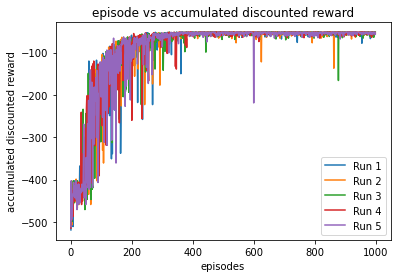

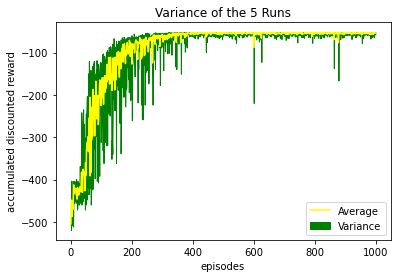

In [13]:
ax1 = plt.subplot(111)
ax1.plot(r_list1,label="Run 1")
ax1.plot(r_list2,label="Run 2")
ax1.plot(r_list3,label="Run 3")
ax1.plot(r_list4,label="Run 4")
ax1.plot(r_list5,label="Run 5")
ax1.set_xlabel('episodes')
ax1.set_ylabel('accumulated discounted reward')
ax1.set_title('episode vs accumulated discounted reward')
plt.legend(loc='best')
plt.show()

averageR = []
highVar = []
lowVar = []
x = []
for i in range(len(r_list1)):
    temp1 = (r_list1[i]+r_list2[i]+r_list3[i]+r_list4[i]+r_list5[i])/5
    temp2 = max(r_list1[i],r_list2[i],r_list3[i],r_list4[i],r_list5[i])
    temp3 = min(r_list1[i],r_list2[i],r_list3[i],r_list4[i],r_list5[i])
    x.append(i)
    averageR.append(temp1)
    highVar.append(temp2)
    lowVar.append(temp3)


ax1 = plt.subplot(111)
ax1.plot(averageR,color= "yellow",label="Average")
ax1.fill_between(x,highVar,lowVar,color= "green",label="Variance")
ax1.set_xlabel('episodes')
ax1.set_ylabel('accumulated discounted reward')
ax1.set_title('Variance of the 5 Runs')
plt.legend(loc='best')
plt.show()

/Users/johnchung/opt/miniconda3/envs/jupyter/lib/python3.8/site-packages/matplotlib/quiver.py:689: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/johnchung/opt/miniconda3/envs/jupyter/lib/python3.8/site-packages/matplotlib/quiver.py:689: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


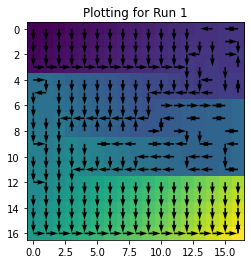

In [14]:
plot_policy_from_qtable(Q1, msg="Plotting for Run 1")

In [15]:
start1 = (random.randint(0, 16),random.randint(0, 16))
START =  start1
_,Q1 = q_learning(gamma,  episodes, epsilon,show=False)
start2 = (random.randint(0, 16),random.randint(0, 16))
START = start2
_,Q2 = q_learning(gamma,  episodes, epsilon,show=False)
start3 = (random.randint(0, 16),random.randint(0, 16))
START = start3
_,Q3 = q_learning(gamma,  episodes, epsilon,show=False)

In [16]:
def trajectory(startingPos,Q):
    pathx = []
    pathy = []
    currPos = startingPos
    pathy.append(currPos[0])
    pathx.append(currPos[1])
    finished = 0
    i = 0
    while finished == 0:
        action = np.argmax(Q[currPos[0], currPos[1], :])
        currPos = s_next_calc(currPos,action)
        pathy.append(currPos[0])
        pathx.append(currPos[1])
        if action == 4:
            finished = 1
        if currPos == (16,16):
            finished = 1
        if i >= 100:
            finished = 1
        i+=1
            
    return pathx,pathy

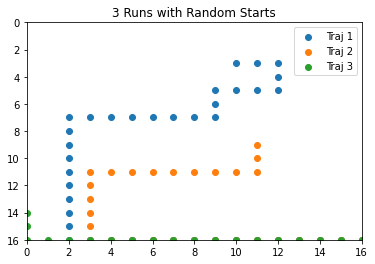

In [17]:
path1x,path1y = trajectory(start1,Q1)
path2x,path2y = trajectory(start2,Q2)
path3x,path3y = trajectory(start3,Q3)



plt.xlim(0,16)
plt.ylim(0,16)
plt.gca().invert_yaxis()
plt.scatter(path1x,path1y,label= "Traj 1")
plt.scatter(path2x,path2y,label= "Traj 2")
plt.scatter(path3x,path3y,label= "Traj 3")
plt.title("3 Runs with Random Starts")
plt.legend(loc='best')
plt.show()

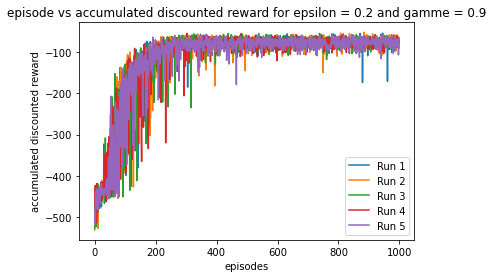

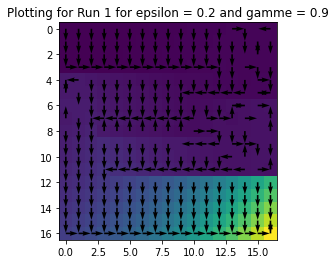

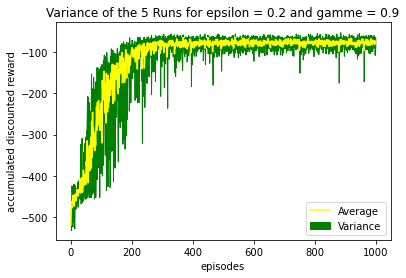

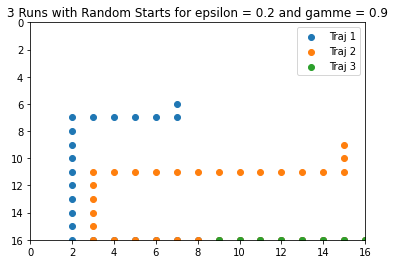

In [27]:
#Using epsilon 0.2 and gamme = 0.9
#Plotting plt.subplot(131)
# example of running
START = (0,0)
episodes = 1000
gamma    = 0.9
epsilon  = 0.2
r_list1,Q1   = q_learning(gamma,  episodes, epsilon,show=False)
r_list2,Q2   = q_learning(gamma,  episodes, epsilon,show=False)
r_list3,Q3   = q_learning(gamma,  episodes, epsilon,show=False)
r_list4,Q4   = q_learning(gamma,  episodes, epsilon,show=False)
r_list5,Q5   = q_learning(gamma,  episodes, epsilon,show=False)
ax1 = plt.subplot(111)
ax1.plot(r_list1,label="Run 1")
ax1.plot(r_list2,label="Run 2")
ax1.plot(r_list3,label="Run 3")
ax1.plot(r_list4,label="Run 4")
ax1.plot(r_list5,label="Run 5")
ax1.set_xlabel('episodes')
ax1.set_ylabel('accumulated discounted reward')
ax1.set_title('episode vs accumulated discounted reward for epsilon = 0.2 and gamme = 0.9')
plt.legend(loc='best')
plt.show()


averageR = []
highVar = []
lowVar = []
x = []
for i in range(len(r_list1)):
    temp1 = (r_list1[i]+r_list2[i]+r_list3[i]+r_list4[i]+r_list5[i])/5
    temp2 = max(r_list1[i],r_list2[i],r_list3[i],r_list4[i],r_list5[i])
    temp3 = min(r_list1[i],r_list2[i],r_list3[i],r_list4[i],r_list5[i])
    x.append(i)
    averageR.append(temp1)
    highVar.append(temp2)
    lowVar.append(temp3)

plot_policy_from_qtable(Q1, msg="Plotting for Run 1 for epsilon = 0.2 and gamme = 0.9")
    
ax1 = plt.subplot(111)
ax1.plot(averageR,color= "yellow",label="Average")
ax1.fill_between(x,highVar,lowVar,color= "green",label="Variance")
ax1.set_xlabel('episodes')
ax1.set_ylabel('accumulated discounted reward')
ax1.set_title('Variance of the 5 Runs for epsilon = 0.2 and gamme = 0.9')
plt.legend(loc='best')
plt.show()




start1 = (random.randint(0, 16),random.randint(0, 16))
START =  start1
_,Q1 = q_learning(gamma,  episodes, epsilon,show=False)
start2 = (random.randint(0, 16),random.randint(0, 16))
START = start2
_,Q2 = q_learning(gamma,  episodes, epsilon,show=False)
start3 = (random.randint(0, 16),random.randint(0, 16))
START = start3
_,Q3 = q_learning(gamma,  episodes, epsilon,show=False)
path1x,path1y = trajectory(start1,Q1)
path2x,path2y = trajectory(start2,Q2)
path3x,path3y = trajectory(start3,Q3)



plt.xlim(0,16)
plt.ylim(0,16)
plt.gca().invert_yaxis()
plt.scatter(path1x,path1y,label= "Traj 1")
plt.scatter(path2x,path2y,label= "Traj 2")
plt.scatter(path3x,path3y,label= "Traj 3")
plt.title("3 Runs with Random Starts for epsilon = 0.2 and gamme = 0.9")
plt.legend(loc='best')
plt.show()


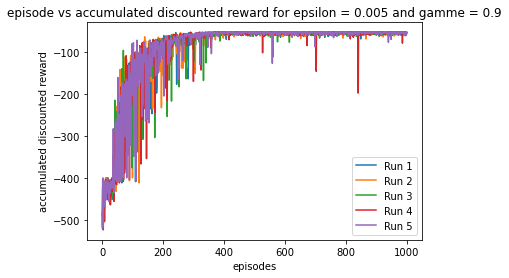

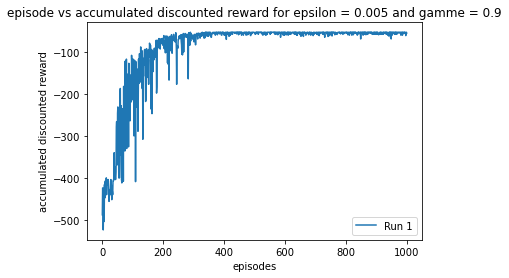

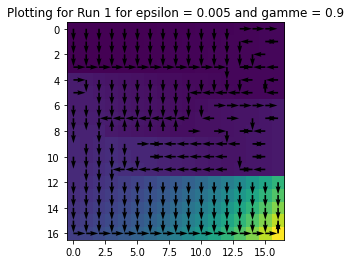

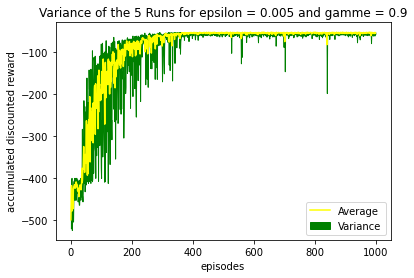

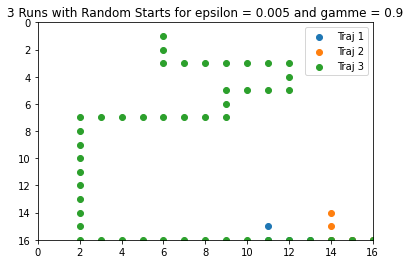

In [24]:
#Using epsilon 0.005 and gamme = 0.9
#Plotting plt.subplot(131)
# example of running
START = (0,0)
episodes = 1000
gamma    = 0.9
epsilon  = 0.005
r_list1,Q1   = q_learning(gamma,  episodes, epsilon,show=False)
r_list2,Q2   = q_learning(gamma,  episodes, epsilon,show=False)
r_list3,Q3   = q_learning(gamma,  episodes, epsilon,show=False)
r_list4,Q4   = q_learning(gamma,  episodes, epsilon,show=False)
r_list5,Q5   = q_learning(gamma,  episodes, epsilon,show=False)
ax1 = plt.subplot(111)
ax1.plot(r_list1,label="Run 1")
ax1.plot(r_list2,label="Run 2")
ax1.plot(r_list3,label="Run 3")
ax1.plot(r_list4,label="Run 4")
ax1.plot(r_list5,label="Run 5")
ax1.set_xlabel('episodes')
ax1.set_ylabel('accumulated discounted reward')
ax1.set_title('episode vs accumulated discounted reward for epsilon = 0.005 and gamme = 0.9')
plt.legend(loc='best')
plt.show()

ax1 = plt.subplot(111)
ax1.plot(r_list1,label="Run 1")
ax1.set_xlabel('episodes')
ax1.set_ylabel('accumulated discounted reward')
ax1.set_title('episode vs accumulated discounted reward for epsilon = 0.005 and gamme = 0.9')
plt.legend(loc='best')
plt.show()


averageR = []
highVar = []
lowVar = []
x = []
for i in range(len(r_list1)):
    temp1 = (r_list1[i]+r_list2[i]+r_list3[i]+r_list4[i]+r_list5[i])/5
    temp2 = max(r_list1[i],r_list2[i],r_list3[i],r_list4[i],r_list5[i])
    temp3 = min(r_list1[i],r_list2[i],r_list3[i],r_list4[i],r_list5[i])
    x.append(i)
    averageR.append(temp1)
    highVar.append(temp2)
    lowVar.append(temp3)

plot_policy_from_qtable(Q1, msg="Plotting for Run 1 for epsilon = 0.005 and gamme = 0.9")


ax1 = plt.subplot(111)
ax1.plot(averageR,color= "yellow",label="Average")
ax1.fill_between(x,highVar,lowVar,color= "green",label="Variance")
ax1.set_xlabel('episodes')
ax1.set_ylabel('accumulated discounted reward')
ax1.set_title('Variance of the 5 Runs for epsilon = 0.005 and gamme = 0.9')
plt.legend(loc='best')
plt.show()




start1 = (random.randint(0, 16),random.randint(0, 16))
START =  start1
_,Q1 = q_learning(gamma,  episodes, epsilon,show=False)
start2 = (random.randint(0, 16),random.randint(0, 16))
START = start2
_,Q2 = q_learning(gamma,  episodes, epsilon,show=False)
start3 = (random.randint(0, 16),random.randint(0, 16))
START = start3
_,Q3 = q_learning(gamma,  episodes, epsilon,show=False)
path1x,path1y = trajectory(start1,Q1)
path2x,path2y = trajectory(start2,Q2)
path3x,path3y = trajectory(start3,Q3)



plt.xlim(0,16)
plt.ylim(0,16)
plt.gca().invert_yaxis()
plt.scatter(path1x,path1y,label= "Traj 1")
plt.scatter(path2x,path2y,label= "Traj 2")
plt.scatter(path3x,path3y,label= "Traj 3")
plt.title("3 Runs with Random Starts for epsilon = 0.005 and gamme = 0.9")
plt.legend(loc='best')
plt.show()



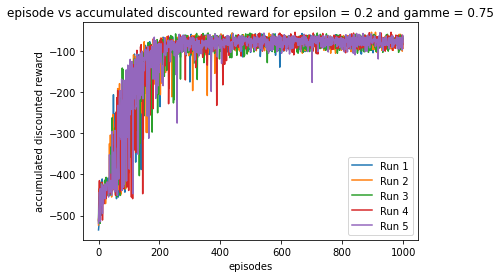

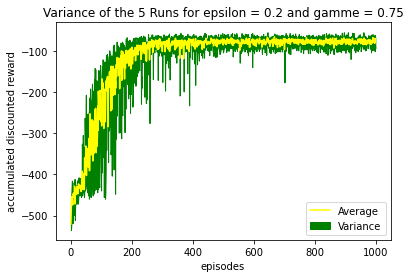

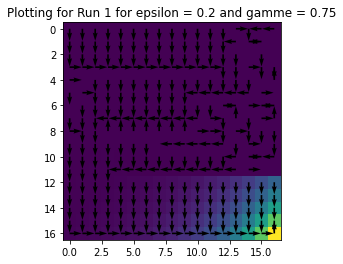

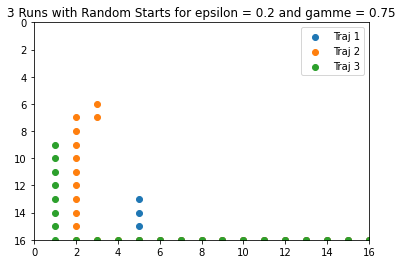

In [25]:
#Using epsilon 0.2 and gamme = 0.75
#Plotting plt.subplot(131)
# example of running
START = (0,0)
episodes = 1000
gamma    = 0.75
epsilon  = 0.2
r_list1,Q1   = q_learning(gamma,  episodes, epsilon,show=False)
r_list2,Q2   = q_learning(gamma,  episodes, epsilon,show=False)
r_list3,Q3   = q_learning(gamma,  episodes, epsilon,show=False)
r_list4,Q4   = q_learning(gamma,  episodes, epsilon,show=False)
r_list5,Q5   = q_learning(gamma,  episodes, epsilon,show=False)
ax1 = plt.subplot(111)
ax1.plot(r_list1,label="Run 1")
ax1.plot(r_list2,label="Run 2")
ax1.plot(r_list3,label="Run 3")
ax1.plot(r_list4,label="Run 4")
ax1.plot(r_list5,label="Run 5")
ax1.set_xlabel('episodes')
ax1.set_ylabel('accumulated discounted reward')
ax1.set_title('episode vs accumulated discounted reward for epsilon = 0.2 and gamme = 0.75')
plt.legend(loc='best')
plt.show()


averageR = []
highVar = []
lowVar = []
x = []
for i in range(len(r_list1)):
    temp1 = (r_list1[i]+r_list2[i]+r_list3[i]+r_list4[i]+r_list5[i])/5
    temp2 = max(r_list1[i],r_list2[i],r_list3[i],r_list4[i],r_list5[i])
    temp3 = min(r_list1[i],r_list2[i],r_list3[i],r_list4[i],r_list5[i])
    x.append(i)
    averageR.append(temp1)
    highVar.append(temp2)
    lowVar.append(temp3)

    

ax1 = plt.subplot(111)
ax1.plot(averageR,color= "yellow",label="Average")
ax1.fill_between(x,highVar,lowVar,color= "green",label="Variance")
ax1.set_xlabel('episodes')
ax1.set_ylabel('accumulated discounted reward')
ax1.set_title('Variance of the 5 Runs for epsilon = 0.2 and gamme = 0.75')
plt.legend(loc='best')
plt.show()

plot_policy_from_qtable(Q1, msg="Plotting for Run 1 for epsilon = 0.2 and gamme = 0.75")



start1 = (random.randint(0, 16),random.randint(0, 16))
START =  start1
_,Q1 = q_learning(gamma,  episodes, epsilon,show=False)
start2 = (random.randint(0, 16),random.randint(0, 16))
START = start2
_,Q2 = q_learning(gamma,  episodes, epsilon,show=False)
start3 = (random.randint(0, 16),random.randint(0, 16))
START = start3
_,Q3 = q_learning(gamma,  episodes, epsilon,show=False)
path1x,path1y = trajectory(start1,Q1)
path2x,path2y = trajectory(start2,Q2)
path3x,path3y = trajectory(start3,Q3)



plt.xlim(0,16)
plt.ylim(0,16)
plt.gca().invert_yaxis()
plt.scatter(path1x,path1y,label= "Traj 1")
plt.scatter(path2x,path2y,label= "Traj 2")
plt.scatter(path3x,path3y,label= "Traj 3")
plt.title("3 Runs with Random Starts for epsilon = 0.2 and gamme = 0.75")
plt.legend(loc='best')
plt.show()



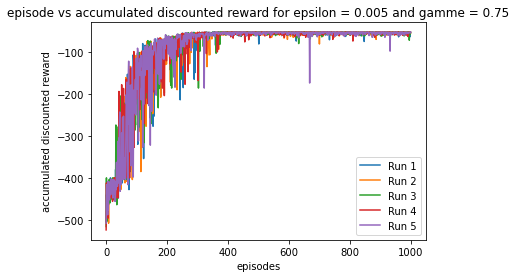

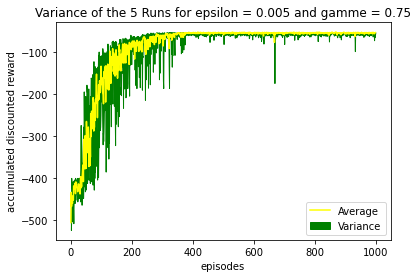

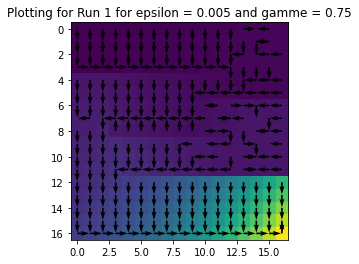

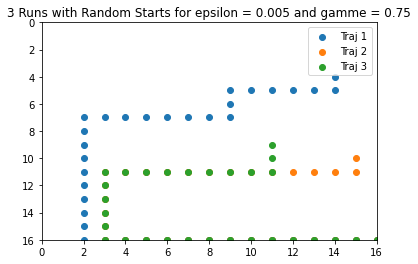

In [26]:
#Using epsilon 0.005 and gamme = 0.75
#Plotting plt.subplot(131)
# example of running
START = (0,0)
episodes = 1000
gamma    = 0.9
epsilon  = 0.005
r_list1,Q1   = q_learning(gamma,  episodes, epsilon,show=False)
r_list2,Q2   = q_learning(gamma,  episodes, epsilon,show=False)
r_list3,Q3   = q_learning(gamma,  episodes, epsilon,show=False)
r_list4,Q4   = q_learning(gamma,  episodes, epsilon,show=False)
r_list5,Q5   = q_learning(gamma,  episodes, epsilon,show=False)
ax1 = plt.subplot(111)
ax1.plot(r_list1,label="Run 1")
ax1.plot(r_list2,label="Run 2")
ax1.plot(r_list3,label="Run 3")
ax1.plot(r_list4,label="Run 4")
ax1.plot(r_list5,label="Run 5")
ax1.set_xlabel('episodes')
ax1.set_ylabel('accumulated discounted reward')
ax1.set_title('episode vs accumulated discounted reward for epsilon = 0.005 and gamme = 0.75')
plt.legend(loc='best')
plt.show()


averageR = []
highVar = []
lowVar = []
x = []
for i in range(len(r_list1)):
    temp1 = (r_list1[i]+r_list2[i]+r_list3[i]+r_list4[i]+r_list5[i])/5
    temp2 = max(r_list1[i],r_list2[i],r_list3[i],r_list4[i],r_list5[i])
    temp3 = min(r_list1[i],r_list2[i],r_list3[i],r_list4[i],r_list5[i])
    x.append(i)
    averageR.append(temp1)
    highVar.append(temp2)
    lowVar.append(temp3)


ax1 = plt.subplot(111)
ax1.plot(averageR,color= "yellow",label="Average")
ax1.fill_between(x,highVar,lowVar,color= "green",label="Variance")
ax1.set_xlabel('episodes')
ax1.set_ylabel('accumulated discounted reward')
ax1.set_title('Variance of the 5 Runs for epsilon = 0.005 and gamme = 0.75')
plt.legend(loc='best')
plt.show()


plot_policy_from_qtable(Q1, msg="Plotting for Run 1 for epsilon = 0.005 and gamme = 0.75")

start1 = (random.randint(0, 16),random.randint(0, 16))
START =  start1
_,Q1 = q_learning(gamma,  episodes, epsilon,show=False)
start2 = (random.randint(0, 16),random.randint(0, 16))
START = start2
_,Q2 = q_learning(gamma,  episodes, epsilon,show=False)
start3 = (random.randint(0, 16),random.randint(0, 16))
START = start3
_,Q3 = q_learning(gamma,  episodes, epsilon,show=False)
path1x,path1y = trajectory(start1,Q1)
path2x,path2y = trajectory(start2,Q2)
path3x,path3y = trajectory(start3,Q3)



plt.xlim(0,16)
plt.ylim(0,16)
plt.gca().invert_yaxis()
plt.scatter(path1x,path1y,label= "Traj 1")
plt.scatter(path2x,path2y,label= "Traj 2")
plt.scatter(path3x,path3y,label= "Traj 3")
plt.title("3 Runs with Random Starts for epsilon = 0.005 and gamme = 0.75")
plt.legend(loc='best')
plt.show()




# Observation and Conclusion

### 1) Decreasing Epsilon
Epsilon chooses the rate of exploring and being greedy. For this project, decreasing epsilon leads to an increase in accumilated discount rewards. The big reason why this project doesn't particularly like exploring is because it already explores by it self through greedy updates and there is no non-optimal end. Although, this is the case fo this project, oftentimes it is actually better to have a balanced epsilon of exploring and being greedy.



### 2) Bias in optimization policy

There is also a bias in states in their optimal action. The further from the optimal path from the start state to the goal state, the less accurate the policy action is. This is due to having a constant starting location where it is less likely to deviate from the optimal path after the optimal path is found. By increasing epsilon, it is more likely to explore, thus find optimal action of other states, however, there states that is far from the optimal policy will have exponentially less likely chance of being explored and updated enough. To fix this, having each episode have different starting location will fix the issue, but will take a little longer to converge.

Ex) Starting location is random per episode testing on 1500 episodes, epsilon = 0.2, and gamme = 0.9 (has better 

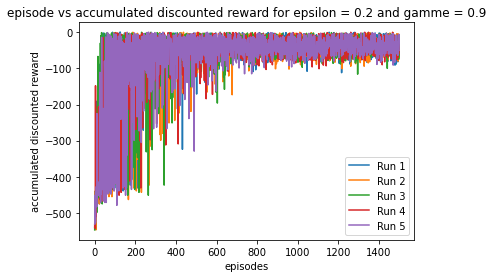

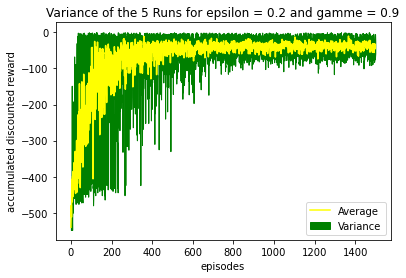

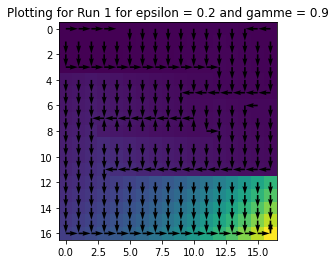

In [32]:
#The agent uses the following function for Q-Learning:
#The agent uses the following function for Q-Learning:
def q_learningRandomStart(gamma, episodes, epsilon, show=True):
    '''This function implements the Q-learning algorithm
    : param gamma: Discounting factor
    : param epsilon: probability not to take an optimal action
    : param episodes: Number of episodes for training
    : returns: dicounted accumulated reward
    '''
    plt.ion()
    # Q - Table
    Q = np.zeros((GRID_SIZE, GRID_SIZE, len(A_LIST)))

    # q-table check points
    Qs = []
    r_list = []
    sum_steps = 0
    for episode in range(episodes):
        
        
        s = (random.randint(0, 16),random.randint(0, 16))
        r_sum = 0
        i = 1
#         print(episode)
#         print(Q[0][0])
        while s != GOAL and i < EPISODE_LENGTH_MAX:
            
            
            # Pick the best known or random action according to eps
            a = choose_action_epsilon(Q, s, epsilon)

            # Take a random action with a transition probability ALPHA
            s_next, r, action_taken = step(s, a)

            # Update Q table
            
            max_Q_next = max(Q[s_next[0]][s_next[1]])
            Q[s[0]][s[1]][action_taken] += r+gamma*max_Q_next-Q[s[0]][s[1]][action_taken] #???
            
            s = s_next #???
            r_sum += r #???
            i += 1
        sum_steps += i
        r_list.append(r_sum)       
        
        if show:
            #if (episode+1) % 10 == 0:
            if (episode+1) % 100 == 0:
                clear_output(wait=True)
                plot_policy_from_qtable(Q, msg="Episode: {}".format(episode+1))

            if (episode+1) % (episodes//5) == 0:
                Qs.append(copy.deepcopy(Q))

    if show:
        clear_output(wait=True)
        for i, q in enumerate(Qs):
            plot_policy_from_qtable(q, msg="Episode: {}".format((1+i)*(episodes//5)))
    
    return r_list,Q

#Using epsilon 0.2 and gamme = 0.9
#Plotting plt.subplot(131)
# example of running
START = (0,0)
episodes = 1500
gamma    = 0.9
epsilon  = 0.2
r_list1,Q1   = q_learningRandomStart(gamma,  episodes, epsilon,show=False)
r_list2,Q2   = q_learningRandomStart(gamma,  episodes, epsilon,show=False)
r_list3,Q3   = q_learningRandomStart(gamma,  episodes, epsilon,show=False)
r_list4,Q4   = q_learningRandomStart(gamma,  episodes, epsilon,show=False)
r_list5,Q5   = q_learningRandomStart(gamma,  episodes, epsilon,show=False)
ax1 = plt.subplot(111)
ax1.plot(r_list1,label="Run 1")
ax1.plot(r_list2,label="Run 2")
ax1.plot(r_list3,label="Run 3")
ax1.plot(r_list4,label="Run 4")
ax1.plot(r_list5,label="Run 5")
ax1.set_xlabel('episodes')
ax1.set_ylabel('accumulated discounted reward')
ax1.set_title('episode vs accumulated discounted reward for epsilon = 0.2 and gamme = 0.9')
plt.legend(loc='best')
plt.show()


averageR = []
highVar = []
lowVar = []
x = []
for i in range(len(r_list1)):
    temp1 = (r_list1[i]+r_list2[i]+r_list3[i]+r_list4[i]+r_list5[i])/5
    temp2 = max(r_list1[i],r_list2[i],r_list3[i],r_list4[i],r_list5[i])
    temp3 = min(r_list1[i],r_list2[i],r_list3[i],r_list4[i],r_list5[i])
    x.append(i)
    averageR.append(temp1)
    highVar.append(temp2)
    lowVar.append(temp3)

    

ax1 = plt.subplot(111)
ax1.plot(averageR,color= "yellow",label="Average")
ax1.fill_between(x,highVar,lowVar,color= "green",label="Variance")
ax1.set_xlabel('episodes')
ax1.set_ylabel('accumulated discounted reward')
ax1.set_title('Variance of the 5 Runs for epsilon = 0.2 and gamme = 0.9')
plt.legend(loc='best')
plt.show()

plot_policy_from_qtable(Q1, msg="Plotting for Run 1 for epsilon = 0.2 and gamme = 0.9")




Comparing random and non-random start with no noise (ALPHA = 0)

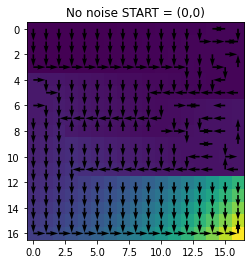

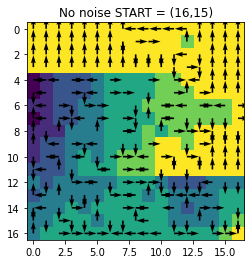

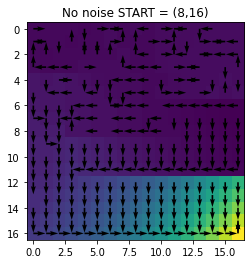

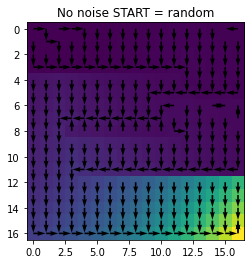

In [33]:
ALPHA = 0
START = (0,0)
episodes = 1500
gamma    = 0.9
epsilon  = 0.2
r_list1,Q1   = q_learning(gamma,  episodes, epsilon,show=False)
START = (16,15)
r_list1,Q2   = q_learning(gamma,  episodes, epsilon,show=False)
START = (8,16)
r_list1,Q3   = q_learning(gamma,  episodes, epsilon,show=False)
r_list1,Q4   = q_learningRandomStart(gamma,  episodes, epsilon,show=False)
plot_policy_from_qtable(Q1, msg="No noise START = (0,0)")
plot_policy_from_qtable(Q2, msg="No noise START = (16,15)")
plot_policy_from_qtable(Q3, msg="No noise START = (8,16)")
plot_policy_from_qtable(Q4, msg="No noise START = random")

### Conclusion
In this project, we seeked to use sample Q-learning to derive a good-enough policy for going around in a maze. From our result, we found that lower epsilon had an increase in the quality of the policy. Compared to the regular Q-learning, sample based Q-learning seeks to create a good enough policy based on samples. Although, this project's regular q_learning was good, it could be further improved by randomly generating start states for each episode.